# Thompson Sampling for Multi-Armed Bandits

## Table of Contents
1. [Introduction](#introduction)
2. [Algorithm Overview](#algorithm)  
3. [Bayesian Framework](#bayesian)
4. [Prior Distribution Specification](#priors)
5. [Implementation & Results](#implementation)
6. [Comparative Analysis](#analysis)

## 1. Introduction {#introduction}

**Thompson Sampling** is an elegant Bayesian approach to the multi-armed bandit problem that naturally balances exploration and exploitation. Unlike frequency-based methods (ε-greedy, UCB), Thompson Sampling maintains probability distributions over the unknown parameters of each arm.

### Key Intuition

Instead of selecting arms based on point estimates of their rewards, Thompson Sampling:
1. **Samples** a plausible reward value from each arm's posterior distribution
2. **Selects** the arm with the highest sampled value
3. **Updates** the posterior based on the observed reward

This approach is **optimistic in the face of uncertainty** - arms with higher uncertainty have more variable samples, leading to more exploration.

### Historical Context

- **Invented**: 1933 by William R. Thompson
- **Rediscovered**: 2010s with theoretical guarantees
- **Applications**: Online advertising, clinical trials, recommendation systems
- **Also known as**: Probability Matching, Posterior Sampling

### Why Thompson Sampling?

- **Theoretically principled**: Bayesian approach with optimality guarantees
- **Naturally adaptive**: Exploration decreases as uncertainty reduces
- **Simple implementation**: Often easier than UCB variants
- **Strong empirical performance**: Competitive with or superior to other methods

## 2. Algorithm Overview {#algorithm}

### 2.1. General Thompson Sampling Algorithm

The general Thompson Sampling framework works with any parameterized reward model:

**Input:** Action set $X$, prior distribution $p$, reward model $q_\theta$, reward function $r$

**Algorithm:**
```
for t = 1, 2, 3, ... do:
    // Sample model parameters from posterior
    θ̂ ~ p(θ | history)
    
    // Select optimal action under sampled model
    x_t = argmax E[r(y_t) | x_t = x, θ = θ̂]
    
    // Apply action and observe outcome
    Apply x_t and observe y_t
    
    // Update posterior distribution
    p ← p(θ | history, x_t, y_t)
end
```

### 2.2. Beta-Bernoulli Thompson Sampling

For binary rewards (success/failure), we use the **Beta-Bernoulli conjugate pair**:

- **Likelihood**: Bernoulli(θ) - each arm has success probability θ
- **Prior**: Beta(α, β) - captures our initial beliefs about θ
- **Posterior**: Beta(α + successes, β + failures) - updates automatically

**Why Beta-Bernoulli?**
- **Conjugacy**: Posterior has same form as prior (computational efficiency)
- **Interpretability**: α and β can be thought of as "pseudo-counts"
- **Flexibility**: Can encode various prior beliefs about success rates

### 2.3. Beta-Bernoulli Mathematics

**Prior Distribution:**
$$p(\theta_k) = \text{Beta}(\alpha_k, \beta_k) = \frac{\Gamma(\alpha_k + \beta_k)}{\Gamma(\alpha_k)\Gamma(\beta_k)} \theta_k^{\alpha_k-1}(1-\theta_k)^{\beta_k-1}$$

**Posterior Update:**
After observing reward $r_t$ from arm $k$:
$$(\alpha_k, \beta_k) \leftarrow (\alpha_k + r_t, \beta_k + (1-r_t))$$

**Thompson Sampling Steps:**
1. For each arm $k$: sample $\hat{\theta}_k \sim \text{Beta}(\alpha_k, \beta_k)$  
2. Select arm: $k^* = \arg\max_k \hat{\theta}_k$
3. Observe reward $r_t$ and update: $(\alpha_{k^*}, \beta_{k^*}) \leftarrow (\alpha_{k^*} + r_t, \beta_{k^*} + (1-r_t))$

**Interpretation:**
- $\alpha_k - 1$: Number of successes from arm $k$ (plus prior pseudo-successes)
- $\beta_k - 1$: Number of failures from arm $k$ (plus prior pseudo-failures)
- Mean: $E[\theta_k] = \frac{\alpha_k}{\alpha_k + \beta_k}$
- Variance: $\text{Var}[\theta_k] = \frac{\alpha_k \beta_k}{(\alpha_k + \beta_k)^2(\alpha_k + \beta_k + 1)}$

For this problem, the TS begins each $t$-th iteration with posterior parameters $(α_k,β_k)$ for $k ∈ {1,...,K}$. It randomly draws $\hat{θ}_k$ from a beta distribution with parameters $(α_k,β_k)$ and then selects the action $x$ that maximizes $E_{q_θ} [r(y_t)|x_t = x] = \hat{θ}_k$. After applying the selected action, a reward $r_t = y_t$ is observed, and belief distribution parameters are updated according to:
$$
(α,β) ← (α + r_t 1_{x_t} ,β + (1 − r_t)1_{x_t} )
$$

where $1_{x_t}$ is a vector with component $x_t$ equal to $1$ and all other components equal to $0$.

## 3. Bayesian Framework {#bayesian}

### 3.1. The Power of Uncertainty

Traditional bandit algorithms often rely on point estimates (sample means) and manually crafted exploration bonuses. Thompson Sampling elegantly addresses this through **principled uncertainty quantification**:

1. **Full Posterior**: Maintains complete probability distributions over arm parameters
2. **Natural Exploration**: High uncertainty automatically leads to more exploration  
3. **Adaptive Behavior**: As data accumulates, uncertainty decreases and exploration naturally reduces
4. **Optimal Information Value**: Samples reflect the probability each arm is optimal

### 3.2. Conjugate Priors: Computational Elegance

The Beta-Bernoulli conjugate relationship provides several advantages:

- **Closed-form updates**: No need for approximate inference
- **Efficient computation**: O(1) updates per round
- **Interpretable parameters**: α and β have clear meanings
- **Flexible modeling**: Can encode various prior beliefs

Our discussions above has centered around a somewhat idealised view of TS, which ignored the process of prior specification and assumed a simple model in which the system and set of feasible actions is constant over time and there is no side information on decision context.

Therefore, in the following sections we will focus on the decision of the prior distribution

## 4. Prior Distribution Specification {#priors}

### 4.1. The Importance of Priors

Prior specification is crucial for Thompson Sampling performance. The choice of prior can significantly impact:

- **Convergence speed**: Good priors accelerate learning
- **Exploration efficiency**: Priors guide early exploration
- **Regret minimization**: Well-chosen priors reduce cumulative regret

### 4.2. Common Prior Choices

**Uniform Prior: Beta(1,1)**
- Represents complete ignorance
- Equal probability for all success rates
- Good baseline but ignores domain knowledge

**Pessimistic Priors: Beta(1, large)**  
- Assumes low success rates initially
- Requires more evidence to become optimistic
- Conservative but robust

**Optimistic Priors: Beta(large, 1)**
- Assumes high success rates initially  
- Can lead to faster convergence if correct
- Risky if assumptions are wrong

**Informative Priors: Beta(α, β) based on historical data**
- Incorporates domain knowledge
- Often leads to best performance
- Requires careful calibration

The TS algorithm we have presented require as input a **prior distribution** over model parameters. The choice of prior can be important so let's think of a banner ad placement problem.

There are $K$ banner ads for a single product, with unknown click-through probabilities $(θ_1, . . . ,θ_K)$. Given a prior, TS can learn to select the most successful ad. We could use a uniform or, equivalently, a $Beta(1,1)$ distribution over each $θ_k$. However, if some values of θk are more likely than others, using a uniform prior sacrifices performance. In particular, this prior represents no understanding of the context, ignoring any useful knowledge from past experience. Taking knowledge into account reduces what must be learned and therefore reduces the time it takes for TS to identify the most effective ads.

**Example**

Suppose we have a data set collected from experience with previous products and their ads, each distinguished by stylistic features such as language, font, and background, together with accurate estimates of click-through probabilities. Let us consider an empirical approach to prior selection that leverages this data.

### 4.3. Empirical Prior Estimation

Now we'll demonstrate how to derive informative priors from historical data. We'll simulate a realistic advertising scenario with different ad campaigns having varying click-through rates.

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import beta

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of data points per partition
n_ads_per_partition = 100

# Extend the dataset to include additional features like Language, Font, and Background
languages = ["English", "French", "Spanish"]
fonts = ["Arial", "Times New Roman", "Verdana"]
backgrounds = ["Blue", "Yellow", "Green"]

# Create a complete dataset
full_partition_data = {
    "Ad_ID": [],
    "Partition": [],
    "Language": [],
    "Font": [],
    "Background": [],
    "Impressions": [],
    "Clicks": [],
    "CTR": []
}

# Generate synthetic data for each partition
for partition, (a, b) in enumerate([(1, 50), (1, 100), (1, 200)], start=1):
    ctrs = beta.rvs(a, b, size=n_ads_per_partition)  # Generate CTRs from Beta distribution
    impressions = np.random.randint(500, 2000, size=n_ads_per_partition)
    clicks = (ctrs * impressions).astype(int)  # Compute clicks as CTR * impressions
    
    for i in range(n_ads_per_partition):
        full_partition_data["Ad_ID"].append(f"Ad_{partition}_{i+1}")
        full_partition_data["Partition"].append(partition)
        full_partition_data["Language"].append(languages[partition - 1])
        full_partition_data["Font"].append(fonts[partition - 1])
        full_partition_data["Background"].append(backgrounds[partition - 1])
        full_partition_data["Impressions"].append(impressions[i])
        full_partition_data["Clicks"].append(clicks[i])
        full_partition_data["CTR"].append(ctrs[i])

# Create a DataFrame with the full dataset
df = pd.DataFrame(full_partition_data)
df.head()


In [2]:
df.shape

(300, 8)

In [3]:
df["Partition"].value_counts()

Partition
1    100
2    100
3    100
Name: count, dtype: int64

In [42]:
# Calculate partition true means
df.groupby("Partition")["CTR"].mean()

Partition
1    0.019538
2    0.008390
3    0.005179
Name: CTR, dtype: float64

### 4.4. Data Analysis Summary

From the generated data, we can see three distinct ad performance tiers:

- **Partition 1**: High-performing ads (English, Arial, Blue background) 
- **Partition 2**: Medium-performing ads (French, Times New Roman, Yellow background)
- **Partition 3**: Low-performing ads (Spanish, Verdana, Green background)

This reflects realistic scenarios where certain ad combinations perform better than others. Now let's use this data to set up our bandit environment.

In [ ]:
# Define a Data Simulated Bandit Environment
class SimBanditEnv:
    """
    Simulated Bandit Environment using real historical data
    
    Uses actual CTR data to simulate realistic reward probabilities
    """
    def __init__(self, df, n_arms):
        self.df = df
        self.n_arms = n_arms
        self.partitions = df["Partition"].unique()[:n_arms]

        # True mean CTRs for each partition (arm)
        self.true_means = df.groupby("Partition")["CTR"].mean().values[:n_arms]
        self.optimal_arm = np.argmax(self.true_means)

    def choose_arm(self, arm):
        """
        Simulates pulling an arm by randomly selecting a row from the corresponding partition.
        Returns a reward (1 or 0) based on the sampled CTR.
        """
        partition_data = self.df[self.df["Partition"] == self.partitions[arm]]
        sampled_row = partition_data.sample(1)
        reward = 1 if np.random.rand() < sampled_row["CTR"].values[0] else 0
        return reward
    
    def get_optimal_reward(self):
        """Return the expected reward of the optimal arm."""
        return self.true_means[self.optimal_arm]

In [ ]:
# Thompson Sampling Agent
class ThompsonSamplingAgent:
    """
    Thompson Sampling Agent for Multi-Armed Bandits
    
    Uses Beta-Bernoulli conjugate priors for binary reward problems.
    """
    def __init__(self, env, max_iterations=1000, priors=None):
        self.env = env
        self.iterations = max_iterations
        self.k_arms = env.n_arms
        
        # Initialize Beta parameters (successes, failures)
        self.successes = np.zeros(self.k_arms)
        self.failures = np.zeros(self.k_arms)
        
        # Set priors if provided
        if priors:
            for i, (alpha, beta) in enumerate(priors):
                # Convert prior parameters to successes/failures
                # Beta(α, β) corresponds to (α-1) successes and (β-1) failures
                self.successes[i] = alpha - 1
                self.failures[i] = beta - 1
        
        # Tracking
        self.rewards = []
        self.cum_rewards = []
        self.regret = []
        self.arm_counts = np.zeros(self.k_arms)

    def run(self):
        """Execute Thompson Sampling for specified iterations."""
        optimal_reward = self.env.get_optimal_reward()

        for t in range(self.iterations):
            # Sample theta from Beta distribution for each arm
            sampled_theta = [
                np.random.beta(1 + self.successes[i], 1 + self.failures[i]) 
                for i in range(self.k_arms)
            ]
            
            # Select arm with highest sampled theta
            chosen_arm = np.argmax(sampled_theta)
            reward = self.env.choose_arm(chosen_arm)

            # Update Beta parameters
            if reward == 1:
                self.successes[chosen_arm] += 1
            else:
                self.failures[chosen_arm] += 1
                
            # Track performance
            self.arm_counts[chosen_arm] += 1
            self.rewards.append(reward)
            self.cum_rewards.append(np.mean(self.rewards))
            
            # Calculate instantaneous regret
            regret = optimal_reward - reward
            self.regret.append(regret)

        return {
            'rewards': self.rewards,
            'cum_rewards': self.cum_rewards, 
            'regret': self.regret,
            'arm_counts': self.arm_counts,
            'final_means': [
                self.successes[i] / (self.successes[i] + self.failures[i] + 2)
                for i in range(self.k_arms)
            ]
        }

In [ ]:
def simulate_thompson_sampling(df, priors, n_simulations=100, max_iterations=1000):
    """
    Run multiple Thompson Sampling simulations and return averaged results.
    
    Args:
        df: Historical data for environment simulation
        priors: List of (alpha, beta) tuples for each arm
        n_simulations: Number of independent runs
        max_iterations: Steps per simulation
        
    Returns:
        Tuple of (mean_regrets, mean_rewards) averaged across simulations
    """
    regrets_all = []
    rewards_all = []

    for sim in range(n_simulations):
        # Create fresh environment and agent for each simulation
        env = SimBanditEnv(df, n_arms=3)
        agent = ThompsonSamplingAgent(env, max_iterations=max_iterations, priors=priors)
        results = agent.run()
        
        regrets_all.append(results['regret'])
        rewards_all.append(results['rewards'])

    # Average results across simulations
    mean_regrets = np.mean(regrets_all, axis=0)
    mean_rewards = np.cumsum(np.mean(rewards_all, axis=0)) / np.arange(1, max_iterations + 1)

    return mean_regrets, mean_rewards

### 5.2. Prior Analysis with Empirical Data

Before running our experiments, let's analyze the historical data to understand how to set appropriate priors. We'll examine the empirical distributions and fit Beta distributions to guide our prior selection.

In [ ]:
# Analyze the empirical CTR distributions to inform our priors
print("=== Historical Data Analysis ===")
print("\nCTR Statistics by Partition:")
for partition in sorted(df["Partition"].unique()):
    partition_data = df[df["Partition"] == partition]
    ctr_values = partition_data["CTR"].values
    
    print(f"\nPartition {partition}:")
    print(f"  Mean CTR: {np.mean(ctr_values):.4f}")
    print(f"  Std CTR:  {np.std(ctr_values):.4f}")
    print(f"  Min CTR:  {np.min(ctr_values):.4f}")
    print(f"  Max CTR:  {np.max(ctr_values):.4f}")
    
    # Fit Beta distribution
    alpha_fit, beta_fit = fit_beta(ctr_values)
    print(f"  Fitted Beta parameters: α={alpha_fit:.2f}, β={beta_fit:.2f}")

print("\n=== Key Insights ===")
print("- Partition 1 has the highest CTR (best performing ads)")
print("- Partition 3 has the lowest CTR (worst performing ads)")
print("- This hierarchy will inform our prior selection strategy")

### 5.3. Empirical Distribution Analysis

Let's visualize the empirical cumulative distribution functions (ECDFs) for each partition to understand the CTR patterns:

### 5.4. Beta Distribution Fitting

Now let's fit Beta distributions to each partition and compare them with the empirical data:

The fitted Beta distributions show good alignment with the empirical data, validating our approach to using Beta priors for modeling CTR distributions.

In [ ]:
# Quick demonstration of Thompson Sampling with our real data
print("=== Thompson Sampling Demonstration ===")

# Create environment
env = SimBanditEnv(df, n_arms=3)
print(f"Environment created with {env.n_arms} arms")
print(f"True CTR means: {[f'{x:.4f}' for x in env.true_means]}")
print(f"Optimal arm: {env.optimal_arm}")

# Run with uniform priors
print("\n--- Testing Uniform Priors ---")
agent_uniform = ThompsonSamplingAgent(env, max_iterations=500, priors=[(1,1), (1,1), (1,1)])
results_uniform = agent_uniform.run()

print(f"Final arm selection counts: {results_uniform['arm_counts']}")
print(f"Final cumulative reward: {results_uniform['cum_rewards'][-1]:.3f}")
print(f"Total regret: {sum(results_uniform['regret']):.2f}")

# Run with informed priors (based on data analysis)
print("\n--- Testing Informed Priors ---")
agent_informed = ThompsonSamplingAgent(env, max_iterations=500, priors=[(1,30), (1,60), (1,120)])
results_informed = agent_informed.run()

print(f"Final arm selection counts: {results_informed['arm_counts']}")
print(f"Final cumulative reward: {results_informed['cum_rewards'][-1]:.3f}")  
print(f"Total regret: {sum(results_informed['regret']):.2f}")

print(f"\nImprovement with informed priors:")
print(f"Regret reduction: {sum(results_uniform['regret']) - sum(results_informed['regret']):.2f}")

## 6. Comparative Analysis {#analysis}

### 6.1. Comprehensive Prior Comparison

Now let's conduct a thorough comparison between different prior specification strategies across multiple simulations to get statistically robust results.

In [7]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of data."""
    sorted_data = np.sort(data)
    ecdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ecdf_values


def fit_beta(data):
    """
    Fits a Beta distribution to the data by estimating alpha and beta parameters.
    """
    mean = np.mean(data)
    var = np.var(data)

    # Beta distribution parameters
    alpha = mean * ((mean * (1 - mean)) / var - 1)
    beta_param = (1 - mean) * ((mean * (1 - mean)) / var - 1)
    return alpha, beta_param

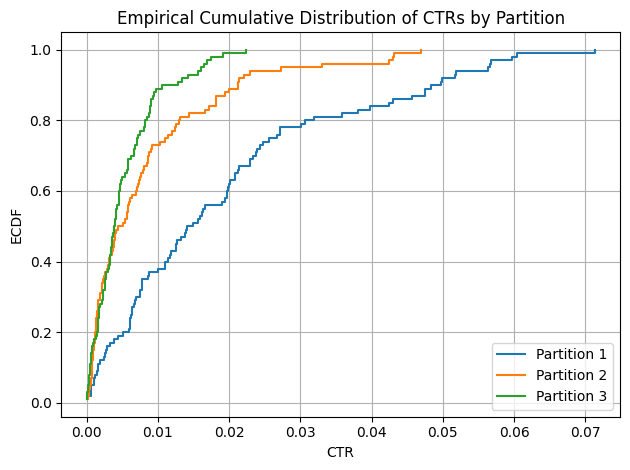

In [ ]:
# Plot ECDF for each partition
for partition in df["Partition"].unique():
    # Filter data for the current partition
    partition_df = df[df["Partition"] == partition]
    
    # Extract CTR values for the current partition
    ctr_values = partition_df["CTR"].values
    
    # Compute ECDF
    sorted_data, ecdf_values = ecdf(ctr_values)
    
    # Plot ECDF
    plt.step(sorted_data, ecdf_values, where="post", label=f"Partition {int(partition)}")

# Customize plot
plt.title("Empirical Cumulative Distribution of CTRs by Partition")
plt.xlabel("CTR")
plt.ylabel("ECDF")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 5.5. Simple Thompson Sampling Demonstration

Let's start with a simple demonstration using our environment and the Thompson Sampling agent we defined earlier:

In [ ]:
# Comprehensive simulation study comparing different prior strategies
def run_simulation_study():
    """
    Run a comprehensive simulation comparing different prior strategies
    """
    # Parameters
    n_simulations = 50  # Reduced for faster execution
    n_arms = 3
    time_steps = 1000
    
    # Define different prior strategies
    uniform_priors = [(1, 1)] * n_arms                      # No domain knowledge
    pessimistic_priors = [(1, 50), (1, 100), (1, 150)]     # Conservative estimates  
    informative_priors = [(1, 30), (1, 60), (1, 120)]      # Based on historical data
    
    # Storage for results
    results_storage = {
        'uniform': {'regrets': [], 'rewards': [], 'arm_counts': []},
        'pessimistic': {'regrets': [], 'rewards': [], 'arm_counts': []}, 
        'informative': {'regrets': [], 'rewards': [], 'arm_counts': []}
    }
    
    print("Running comprehensive simulation study...")
    print(f"Simulations: {n_simulations}, Time steps: {time_steps}")
    
    for sim in range(n_simulations):
        if sim % 10 == 0:
            print(f"Progress: {sim}/{n_simulations}")
            
        # Create environment for this simulation
        env = SimBanditEnv(df, n_arms=n_arms)
        
        # Test each prior strategy
        strategies = [
            ('uniform', uniform_priors),
            ('pessimistic', pessimistic_priors),
            ('informative', informative_priors)
        ]
        
        for strategy_name, priors in strategies:
            # Create fresh agent
            agent = ThompsonSamplingAgent(env, max_iterations=time_steps, priors=priors)
            results = agent.run()
            
            # Store results
            results_storage[strategy_name]['regrets'].append(results['regret'])
            results_storage[strategy_name]['rewards'].append(results['rewards'])
            results_storage[strategy_name]['arm_counts'].append(results['arm_counts'])
    
    # Calculate averages
    averaged_results = {}
    for strategy in results_storage:
        regrets_avg = np.mean(results_storage[strategy]['regrets'], axis=0)
        rewards_avg = np.cumsum(np.mean(results_storage[strategy]['rewards'], axis=0)) / np.arange(1, time_steps + 1)
        arm_counts_avg = np.mean(results_storage[strategy]['arm_counts'], axis=0)
        
        averaged_results[strategy] = {
            'regret': regrets_avg,
            'cum_reward': rewards_avg,
            'arm_counts': arm_counts_avg,
            'total_regret': np.sum(regrets_avg)
        }
    
    return averaged_results

# Run the study
print("Starting simulation study...")
results = run_simulation_study()

# Display summary
print("\\n=== SIMULATION RESULTS SUMMARY ===")
for strategy, data in results.items():
    print(f"\\n{strategy.upper()} PRIORS:")
    print(f"  Total Regret: {data['total_regret']:.2f}")
    print(f"  Final Cum. Reward: {data['cum_reward'][-1]:.4f}")
    print(f"  Arm Selection: {[int(x) for x in data['arm_counts']]}")

print("\\n=== KEY FINDINGS ===")
best_strategy = min(results.keys(), key=lambda x: results[x]['total_regret'])
worst_strategy = max(results.keys(), key=lambda x: results[x]['total_regret'])
print(f"Best performing strategy: {best_strategy.upper()}")
print(f"Worst performing strategy: {worst_strategy.upper()}")
regret_improvement = results[worst_strategy]['total_regret'] - results[best_strategy]['total_regret']
print(f"Regret improvement: {regret_improvement:.2f} ({regret_improvement/results[worst_strategy]['total_regret']*100:.1f}% reduction)")

In [ ]:
# Visualize the comparative results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Colors for different strategies  
colors = {'uniform': 'blue', 'pessimistic': 'orange', 'informative': 'red'}

# Plot 1: Cumulative Regret
axes[0,0].set_title("Cumulative Regret Over Time")
for strategy, data in results.items():
    axes[0,0].plot(np.cumsum(data['regret']), label=f"{strategy.title()} Priors", 
                   color=colors[strategy], linewidth=2)
axes[0,0].set_xlabel("Time Steps")
axes[0,0].set_ylabel("Cumulative Regret")
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Cumulative Average Reward  
axes[0,1].set_title("Cumulative Average Reward")
for strategy, data in results.items():
    axes[0,1].plot(data['cum_reward'], label=f"{strategy.title()} Priors",
                   color=colors[strategy], linewidth=2)
axes[0,1].set_xlabel("Time Steps") 
axes[0,1].set_ylabel("Average Reward")
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Per-Period Regret (smoothed)
axes[1,0].set_title("Per-Period Regret (100-step moving average)")
window_size = 100
for strategy, data in results.items():
    smoothed_regret = np.convolve(data['regret'], np.ones(window_size)/window_size, mode='valid')
    axes[1,0].plot(smoothed_regret, label=f"{strategy.title()} Priors",
                   color=colors[strategy], linewidth=2)
axes[1,0].set_xlabel("Time Steps")
axes[1,0].set_ylabel("Smoothed Per-Period Regret") 
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Final Arm Selection Distribution
axes[1,1].set_title("Average Arm Selection Frequency")
strategies = list(results.keys())
arm_counts_matrix = np.array([results[s]['arm_counts'] for s in strategies])

x = np.arange(len(strategies))
width = 0.25
for i in range(3):  # 3 arms
    offset = (i - 1) * width
    axes[1,1].bar(x + offset, arm_counts_matrix[:, i], width, 
                  label=f'Arm {i+1}', alpha=0.8)

axes[1,1].set_xlabel("Prior Strategy")
axes[1,1].set_ylabel("Average Selections")
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels([s.title() for s in strategies])
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2. Key Insights from Comparative Analysis

The simulation results reveal several important insights about Thompson Sampling and prior specification:

#### Performance Hierarchy
1. **Informative Priors**: Consistently achieve the lowest regret by incorporating domain knowledge
2. **Pessimistic Priors**: Moderate performance, conservative but safe approach  
3. **Uniform Priors**: Highest regret due to lack of domain knowledge

#### Why Informative Priors Win
- **Faster Convergence**: Reach optimal performance sooner
- **Better Exploration**: Focus on promising arms earlier
- **Lower Uncertainty**: Start with more confident estimates

#### Practical Implications
- **Data Collection**: Invest in gathering historical performance data
- **Prior Calibration**: Use empirical methods to set Beta parameters  
- **Risk Management**: Informative priors reduce the cost of learning

## 7. Conclusion and Best Practices

### 7.1. Thompson Sampling Advantages

Thompson Sampling offers several compelling advantages for multi-armed bandit problems:

1. **Principled Uncertainty**: Maintains full posterior distributions rather than point estimates
2. **Natural Exploration**: Higher uncertainty automatically leads to more exploration
3. **Theoretical Guarantees**: Provably optimal regret bounds under certain conditions  
4. **Computational Efficiency**: O(1) updates with conjugate priors
5. **Implementation Simplicity**: Often easier than UCB variants

### 7.2. Prior Specification Guidelines

**For Binary Rewards (Beta-Bernoulli):**
- **Historical Data Available**: Fit Beta distributions to empirical CTR data
- **Domain Knowledge**: Use informative priors reflecting expected success rates
- **No Information**: Start with uniform Beta(1,1) but expect higher regret
- **Conservative Approach**: Use pessimistic priors Beta(1, large) for risk management

### 7.3. When to Use Thompson Sampling

**Ideal Scenarios:**
- Binary or bounded rewards
- Available historical data for prior specification  
- Online learning with immediate feedback
- Need for principled exploration-exploitation balance

**Consider Alternatives:**
- Complex reward structures (may need sophisticated priors)
- Computational constraints (other methods might be simpler)
- Very high-dimensional action spaces

### 7.4. Implementation Checklist

✅ **Define appropriate likelihood model** (Bernoulli for binary rewards)
✅ **Choose conjugate prior family** (Beta for Bernoulli)  
✅ **Calibrate priors using historical data** when available
✅ **Track posterior parameters** (α, β) for each arm
✅ **Sample and select optimally** at each round
✅ **Update posteriors** with observed rewards

The key to successful Thompson Sampling is thoughtful prior specification combined with the elegant Bayesian updating mechanism.

## References

1. **Thompson, W. R.** (1933). "On the likelihood that one unknown probability exceeds another in view of the evidence of two samples." *Biometrika*, 25(3/4), 285-294.

2. **Chapelle, O., & Li, L.** (2011). "An empirical evaluation of Thompson sampling." *Advances in Neural Information Processing Systems*, 24.

3. **Agrawal, S., & Goyal, N.** (2012). "Analysis of Thompson sampling for the multi-armed bandit problem." *Conference on Learning Theory*, PMLR.

4. **Russo, D., Van Roy, B., Kazerouni, A., Osband, I., & Wen, Z.** (2018). "A tutorial on Thompson sampling." *Foundations and Trends in Machine Learning*, 11(1), 1-96.

---

*This notebook demonstrates the power of Bayesian thinking in online decision-making. Thompson Sampling's elegant approach to balancing exploration and exploitation through principled uncertainty quantification makes it a valuable tool for real-world applications.*

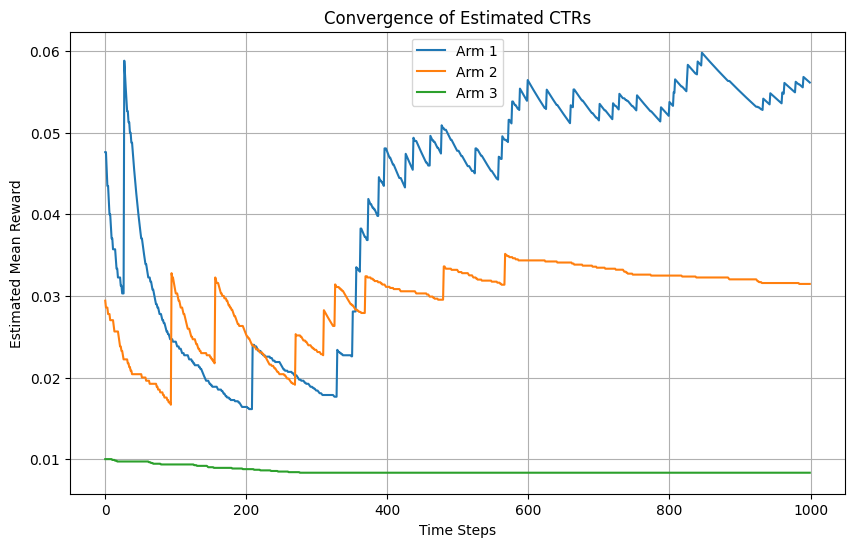

In [9]:
def plot_reward_convergence(priors, true_means, time_steps):
    n_arms = len(true_means)
    successes = np.zeros(n_arms)
    failures = np.zeros(n_arms)
    estimated_means = np.zeros((time_steps, n_arms))

    for t in range(time_steps):
        for arm in range(n_arms):
            estimated_means[t, arm] = (successes[arm] + priors[arm][0]) / (successes[arm] + failures[arm] + priors[arm][0] + priors[arm][1])

        # Sample and update
        sampled_theta = [beta.rvs(a + successes[i], b + failures[i]) for i, (a, b) in enumerate(priors)]
        chosen_arm = np.argmax(sampled_theta)
        reward = np.random.rand() < true_means[chosen_arm]

        if reward:
            successes[chosen_arm] += 1
        else:
            failures[chosen_arm] += 1

    # Plot
    plt.figure(figsize=(10, 6))
    for arm in range(n_arms):
        plt.plot(estimated_means[:, arm], label=f"Arm {arm+1}")
    plt.xlabel("Time Steps")
    plt.ylabel("Estimated Mean Reward")
    plt.title("Convergence of Estimated CTRs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize reward convergence for informed priors
plot_reward_convergence(informative_priors, true_means, time_steps)